# Importar dependecias

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


In [2]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
# Directorios de entrada y salida
input_dir = "org_cats/"
output_dir = "logaritmo/"

# Obtener la lista de archivos en el directorio de entrada
files = os.listdir(input_dir)

# Iterar sobre los archivos en el directorio de entrada
for file in files:
    # Cargar la imagen en formato BGR
    img = cv2.imread(os.path.join(input_dir, file), cv2.IMREAD_COLOR)
    
    # Separar los canales de la imagen
    b, g, r = cv2.split(img)
    
    # Generar una constante aleatoria para la transformación logarítmica
    alpha = np.random.uniform(0.01, 10.0)
    
    # Aplicar la transformación logarítmica a cada canal
    b_log = (255.0 / np.log(1 + 255)) * np.log(1 + alpha * b)
    g_log = (255.0 / np.log(1 + 255)) * np.log(1 + alpha * g)
    r_log = (255.0 / np.log(1 + 255)) * np.log(1 + alpha * r)
    
    # Combinar los canales nuevamente
    img_log = cv2.merge((b_log, g_log, r_log))
    img_log = np.array(img_log, dtype=np.uint8)
    
    # Guardar la imagen transformada en el directorio de salida
    cv2.imwrite(os.path.join(output_dir, file), img_log)

# Creación de conjunto de entrenamiento a partir de un dataset origen

In [4]:
def create_train_images():

    ruta_org = 'logaritmo/'
    ruta_trn = 'trn_cats/'
    
    nombres_archivos = os.listdir(ruta_org)
    
    for nombre_archivo in nombres_archivos:
        ruta_archivo_org = ruta_org + nombre_archivo
        img = cv2.imread(ruta_archivo_org)
        alto, ancho = img.shape[:2]
        ruta_archivo_trn = ruta_trn + nombre_archivo
        cv2.imwrite(ruta_archivo_trn, img)


In [5]:
create_train_images()

In [6]:
INPATH = 'trn_cats'
OUTPATH = 'org_cats'
CKPATH = 'checkpoints'

In [8]:
trn_cats = os.listdir(INPATH)

n = 500
train_n = round(n*0.80)

#randomizar listado

randurls = np.copy(trn_cats)
np.random.shuffle(randurls)

#partición train/test

tr_urls = randurls[:train_n]
test_urls = randurls[train_n:n]

print(len(trn_cats), len(tr_urls), len(test_urls))

2709 400 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


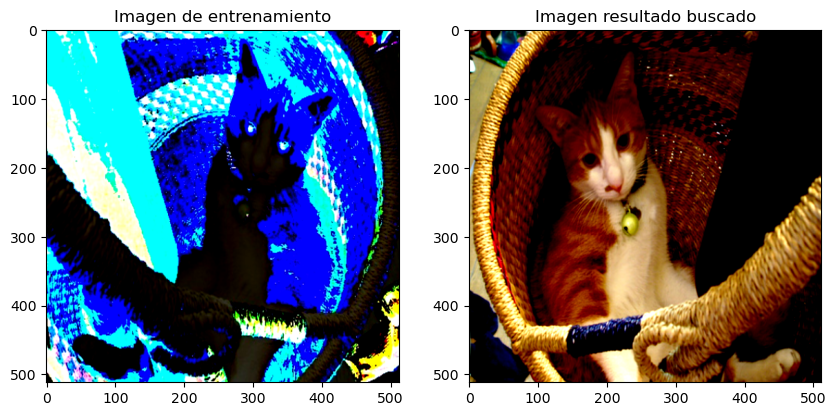

In [9]:
ancho = 512
alto = 512

def reescalado(inimg, outimg, height, width):
    inimg = tf.image.resize(inimg, [height,width])
    outimg = tf.image.resize(outimg, [height,width])
    
    return inimg,outimg

def normalizado(inimg, outimg):
    inimg = (inimg/127.5) -1
    outimg = (outimg/127.5) -1
    
    return inimg,outimg

def random_jitter(inimg, outimg):
    inimg, outimg = reescalado(inimg, outimg, 542, 542)
    
    stacked_image = tf.stack([inimg,outimg], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2,alto,ancho, 3])
    
    inimg, outimg = cropped_image[0], cropped_image[1]
    
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        inimg = tf.image.flip_left_right(inimg)
        outimg = tf.image.flip_left_right(outimg)
    
    return inimg, outimg

def load_image(filename, augment = True):
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH+'/'+filename)),tf.float32)[..., :3]
    outimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH+'/'+filename)),tf.float32)[..., :3]
    
    inimg,outimg = reescalado(inimg,outimg,alto,ancho)
    
    if augment:
        inimg,outimg = random_jitter(inimg,outimg)
        
    inimg, outimg = normalizado(inimg,outimg)
    
    return inimg, outimg

#Funciones finales para pasar a tensorflow, con alteración de datos para entrenamiento y sin alteración para el test

def load_train_image(filename):
    return load_image(filename, augment = True)

def load_test_image(filename):
    return load_image(filename, augment = False)

# Crear la figura con dos subplots

fig, axs = plt.subplots(1, 2, figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Imagen de entrenamiento')
plt.imshow((load_train_image(randurls[0])[0]) + 1 / 2 )

plt.subplot(1,2,2)
plt.title('Imagen resultado buscado')
plt.imshow((load_train_image(randurls[0])[1]) + 1 / 2 )


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(test_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [11]:
from tensorflow.keras import * 
from tensorflow.keras.layers import * 

In [12]:
def downsample(filters, apply_batchnorm=True):
    result = Sequential()
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    #Capa convolucional
    result.add(Conv2D(filters,
                      kernel_size=4 ,
                      strides=2,
                      padding="same",
                      kernel_initializer=initializer,
                      use_bias=not apply_batchnorm ))
    
    if apply_batchnorm:
        #Capa batch normalization
        result.add(BatchNormalization())
    
    #Capa de activacion
    result.add(LeakyReLU())
    
    return result


In [13]:
def upsample(filters, apply_dropout=False):
    result = Sequential()
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    #Capa convolucional
    result.add(Conv2DTranspose(filters,
                               kernel_size=4 ,
                               strides=2,
                               padding="same",
                               kernel_initializer=initializer,
                               use_bias=False ))
    
    
    #Capa batch normalization
    result.add(BatchNormalization())
    
    if apply_dropout:
        #Capa de Dropout
        result.add(Dropout(0.5))
    #Capa de activacion
    result.add(ReLU())
    
    return result


# Generación de la arquitectura

In [14]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    
    down_stack = [
        downsample(64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128),  # (batch_size, 64, 64, 128)
        downsample(256),  # (batch_size, 32, 32, 256)
        downsample(512),  # (batch_size, 16, 16, 512)
        downsample(512),  # (batch_size, 8, 8, 512)
        downsample(512),  # (batch_size, 4, 4, 512)
        downsample(512),  # (batch_size, 2, 2, 512)
        downsample(512),  # (batch_size, 1, 1, 512)
      ]
    
    up_stack = [
        upsample(512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512),  # (batch_size, 16, 16, 1024)
        upsample(256),  # (batch_size, 32, 32, 512)
        upsample(128),  # (batch_size, 64, 64, 256)
        upsample(64),  # (batch_size, 128, 128, 128)
      ]
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    last = Conv2DTranspose(filters=3,
                           kernel_size=4,
                           strides=2,
                           padding="same",
                           kernel_initializer= initializer,
                           activation="tanh")
    x = inputs
    s = []
    concat = Concatenate()
    #Conectar capas con la siguiente
    
    for down in down_stack:
        x = down(x)
        s.append(x)
        
    s = reversed(s[:-1])    
    for up,sk in zip(up_stack, s):
        x = up(x)
        x = concat([x, sk])
    
    last =  last(x)

    return Model(inputs=inputs, outputs= last)

generator = Generator()


In [15]:
def Discriminator():
    ini = Input(shape=[None, None, 3], name="input_img")
    gen = Input(shape=[None, None, 3], name="gener_img")
    
    con = concatenate([ini,gen])
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    down1 = downsample(64, apply_batchnorm=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)
    
    last = tf.keras.layers.Conv2D(filters=1,
                                  kernel_size=4,
                                  strides=1,
                                  kernel_initializer=initializer,
                                  padding="same")(down4)
    
    return tf.keras.Model(inputs=[ini, gen], outputs=last)


discriminator = Discriminator()
    

In [16]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

In [17]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss
    

In [18]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [20]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
    
    prediction = model(test_input, training = False)
    
    if save_filename:
        tf.keras.preprocessing.image.save_img('output/' + save_filename + '.jpg', prediction[0,...])
    
    plt.figure(figsize=(10,10))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    if display_imgs:
        for i in range(3):
            plt.subplot(1,3,i+1)
            plt.title(title[i])
            plt.imshow(display_list[i]*0.5 + 0.5)
            plt.axis('off')
    plt.show()

In [21]:
@tf.function()
def train_step(input_image, target):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
        
        output_image = generator (input_image, training = True)
        output_gen_discr = discriminator([output_image, input_image], training=True)
        output_trg_discr = discriminator([target, input_image], training=True)

        discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
        gen_loss = generator_loss(output_gen_discr, output_image, target)
        
        generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        
        discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [22]:
from IPython.display import clear_output

def train(dataset, epochs):
    for epoch in range(epochs):
        
        imgi = 0
        for input_image, target in dataset:
            print('epoch' + str(epoch)+ '- train '+ str(imgi)+'/'+ str(len(tr_urls)))
            imgi+=1
            train_step(input_image,target)
            
            clear_output(wait=True)
            
        imgi = 0    
        for inp, tar in test_dataset.take(5):
            generate_images(generator, inp, tar, str(imgi)+ '_' + str(epoch), display_imgs=True)
            imgi+=1
            
        if (epoch+1)%25 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [23]:
train(train_dataset, 100)

epoch25- train 45/400


KeyboardInterrupt: 